# Import libraries

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/shwetank/code/makemore-utils-nbs')
from utils import create_dataset, evaluate_loss, generate
from torch.optim import Adam
import random
from models import Xformer_Scratch as Xformer
from sklearn.manifold import TSNE
import numpy as np
import torch
import math

# Check if accelerator is available on your system 

In [2]:
# Setup device - check if accelerator is available
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    # Check if MPS is available
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        # Fall back to CPU
        device = torch.device("cpu")

print("Device selected:", device)

Device selected: cuda


# Read the data and create training and validation sets

In [3]:
## Read file and create training and validation sets
names, vocab, max_length = create_dataset('../names.txt')
# print(len(names), vocab, max_length)
seed_value = 42
random.seed(seed_value)
n1 = int(0.9*len(names))

## Add stop token
names = ['.' + n + '.' for n in names]

## Check that dataset is shuffled
random.shuffle(names)
# print(names[0:5], names_ss[0:5]) 
train_data = names[:n1]
val_data = names[n1:]

print(train_data[0:5])
print(val_data[0:5])

['.yuheng.', '.diondre.', '.xavien.', '.jori.', '.juanluis.']
['.mustafa.', '.reuben.', '.kahlel.', '.balian.', '.izael.']


# Create a character level tokenizer - simplest version of what is possible

In [4]:
# Create functions to encode and decode the string data to torch tensor and back
stoi = {s: i+1 for i, s in enumerate(vocab)} 
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)
print(stoi)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [5]:
def encode(text_batch: list) -> list:
    tokens = []
    for ridx, row in enumerate(text_batch):
        # Convert row to indices, with padding or truncation as necessary
        row_indices = [stoi[r] for r in row][:max_length]
        tokens.append(row_indices)
    
    return tokens

def decode(token_batch: list) -> list:
    text_batch = []
    for row in token_batch:
        text_batch.append(''.join(itos[r] for r in row))
    
    return text_batch

In [6]:
## Check encoding and decoding
batch_size = 4
train_batch = train_data[:batch_size]
print(train_batch)
print(encode(train_batch))
print(decode(encode(train_batch)))

['.yuheng.', '.diondre.', '.xavien.', '.jori.']
[[0, 25, 21, 8, 5, 14, 7, 0], [0, 4, 9, 15, 14, 4, 18, 5, 0], [0, 24, 1, 22, 9, 5, 14, 0], [0, 10, 15, 18, 9, 0]]
['.yuheng.', '.diondre.', '.xavien.', '.jori.']


In [7]:
## Tokenize the train and val datasets and covert them to token indices
encoded_train_data = encode(train_data)
encoded_val_data = encode(val_data)

# Create a model and run a forward pass

In [8]:
## Function to create a batch
def get_batch(data, max_encoded_length = max_length + 2,batch_size=4):
    x = torch.zeros(batch_size, max_encoded_length, dtype=torch.long)
    y = torch.zeros(batch_size, max_encoded_length, dtype=torch.long)
    # print(data)
    row_nums = torch.randint(len(data), size=(batch_size,))
    for i,n in enumerate(row_nums):
        row_len = len(data[n])
        x[i,1:1+row_len] = torch.tensor(data[n])
        y[i,:row_len] = torch.tensor(data[n])
        y[i,row_len:] = -1

    x = x[:,1:]
    y = y[:,1:]
    return x.to(device),y.to(device)

In [9]:
## Print out a batch and see how it looks
x,y  = get_batch(encoded_train_data)
print(x)
print(y)
print(x.shape,y.shape)

tensor([[ 0, 11,  1,  9, 12, 15, 14,  9,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0, 11,  1, 13,  2,  5, 18,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0, 10,  1,  8, 13,  1, 18,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0, 12,  9, 12,  9,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]],
       device='cuda:0')
tensor([[11,  1,  9, 12, 15, 14,  9,  0, -1, -1, -1, -1, -1, -1, -1, -1],
        [11,  1, 13,  2,  5, 18,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [10,  1,  8, 13,  1, 18,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [12,  9, 12,  9,  5,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]],
       device='cuda:0')
torch.Size([4, 16]) torch.Size([4, 16])


In [10]:
## Hyperparameters
batch_size = 64
emb_dim = 384
num_heads = 6
dropout = 0.2

In [11]:
## Run a forward pass
vocab_size = len(vocab) + 1 # +1 for '.' stop character
block_length = max_length + 1
model = Xformer(emb_dim, vocab_size, num_heads, block_length, dropout).to(device)
total_params = sum(p.numel() for p in model.parameters())
print("Total parameters:", total_params)
xb, yb = get_batch(encoded_train_data,batch_size=batch_size)
# print(xb.shape, yb.shape)
# print(xb)
# print(yb)
logits, loss = model(xb,yb)
print('Measured loss:',loss.item())
expected_loss = -math.log(1/26.)
print('Expected loss assuming uniform:', expected_loss)

Total parameters: 10672539
Measured loss: 3.435683250427246
Expected loss assuming uniform: 3.258096538021482


# Choose a reasonable learning rate to train your model

In [12]:
# Function to do a learning rate sweep
def get_lr_loss(model, optimizer, dataset, batch_size, num_epochs, device, lr_start_exp=-3, lr_end_exp=0.5):

    lrexp = torch.linspace(lr_start_exp, lr_end_exp, num_epochs, requires_grad=False)
    lrs_val = 10**lrexp

    lri = []
    lossi = []
    # Training loop with mini-batches and lr sweep
    for epoch in range(num_epochs):

        ## Set learning rate
        for g in optimizer.param_groups:
            g['lr'] = lrs_val[epoch]

        xb, yb = get_batch(dataset, batch_size=256)


        # Forward pass
        _, loss = model(xb, yb)
        lri.append(lrs_val[epoch])
        lossi.append(loss.item())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return lri, lossi

In [13]:
# # Run the learning rate sweep and plot the results
# import matplotlib.pyplot as plt
# num_epochs = 100
# batch_size = 128
# optimizer = Adam(model.parameters())
# lri, lossi =  get_lr_loss(model, optimizer, encoded_train_data, batch_size, num_epochs, device, -4, -1)
# plt.plot(lri, lossi)
# # Add labels to the x-axis and y-axis
# plt.xlabel('LR (Learning Rate)')
# plt.ylabel('Loss')

# Run a training loop

In [14]:
## Initialize loss matrices and batch size
tr_loss = []
val_loss = []
tr_loss_raw = []
batch_size = 128

In [17]:
## Initialize training parameters
lr = 1e-5
optimizer = Adam(model.parameters(), lr=lr)
n_epochs = 1000

for steps in range(n_epochs):
    xtr, ytr = get_batch(encoded_train_data, batch_size=batch_size)
    xval, yval = get_batch(encoded_val_data, batch_size=batch_size)
    eval_dataset = {'train': (xtr,ytr), 'val': (xval, yval)}
    logits, loss = model(xtr,ytr)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    tr_lossi, val_lossi = evaluate_loss(model, eval_dataset, num_batches=8)
    tr_loss.append(tr_lossi)
    val_loss.append(val_lossi)
    tr_loss_raw.append(loss.item())

    ## Print losses
    if steps % 100 == 0:
        print(steps, ' --> train loss: ', tr_lossi, 'validation loss: ', val_lossi, 'single shot loss:', loss.item())

0  --> train loss:  1.945632815361023 validation loss:  2.10854172706604 single shot loss: 1.9808601140975952
100  --> train loss:  1.945947527885437 validation loss:  1.9983844757080078 single shot loss: 2.004608392715454
200  --> train loss:  1.8628575801849365 validation loss:  1.9796627759933472 single shot loss: 1.926040768623352
300  --> train loss:  1.9263055324554443 validation loss:  1.950520396232605 single shot loss: 1.9728144407272339
400  --> train loss:  1.9845973253250122 validation loss:  2.0428688526153564 single shot loss: 2.0415403842926025
500  --> train loss:  1.9225943088531494 validation loss:  2.0499966144561768 single shot loss: 1.9704073667526245
600  --> train loss:  1.9672107696533203 validation loss:  2.043937921524048 single shot loss: 2.017951488494873
700  --> train loss:  1.8700963258743286 validation loss:  1.9983110427856445 single shot loss: 1.9203630685806274
800  --> train loss:  1.950236439704895 validation loss:  1.98252272605896 single shot loss

training loss:  1.9335
validation loss:  1.9895


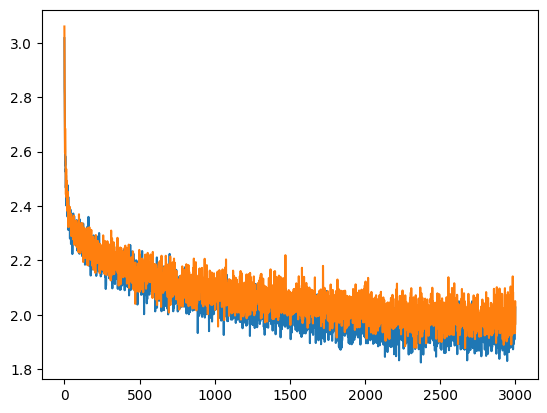

In [18]:
## Plot loss 
import matplotlib.pyplot as plt

plt.plot(tr_loss)
plt.plot(val_loss)

print('training loss: ', round(torch.mean(torch.tensor(tr_loss[-100:])).item(),4)), 
print('validation loss: ', round((torch.mean(torch.tensor(val_loss[-100:]))).item(),4))

# Evaluation your results

In [19]:
## Function to generate tokens and decode them
def print_samples(model, max_new_tokens, device, num=8):
    """ samples from the model and pretty prints the decoded samples """
    X_init = torch.zeros((num, 1), dtype=torch.long).to(device)
    X_samp = generate(model, X_init, max_new_tokens, device)[:,1:].tolist()
    sample_list = []
    for row in X_samp:
        crop_index = row.index(0) if 0 in row else len(row)
        row = row[:crop_index]
        sample_list.append(row)

    print(decode(sample_list))
    

In [21]:
## Pretty print the samples
print_samples(model, max_length, device, 8)

['traydan', 'alvia', 'leeigh', 'deanna', 'tianna', 'tainna', 'takai', 'lasser']


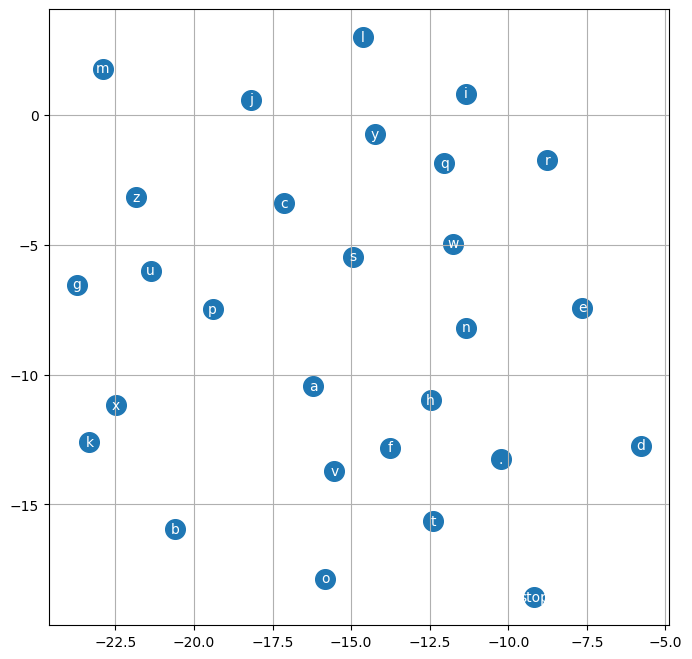

In [22]:
## Plot tsne or pca for embeddings
embeddings_matrix = model.token_embedding.weight.data.cpu().numpy()

# Create vectors for ticklabels
ticklabels = list(itos.values())
ticklabels.insert(0,'stop')
x_ticklabel_vec = np.arange(len(ticklabels))
y_ticklabel_vec = np.arange(len(ticklabels))
# print(ticklabels)

# t-SNE example:
tsne = TSNE(n_components=2, perplexity=5)
reduced_embeddings = tsne.fit_transform(embeddings_matrix)

# visualize dimensions 0 and 1 of the embedding matrix for all characters
plt.figure(figsize=(8,8))
plt.scatter(reduced_embeddings[:,0].data, reduced_embeddings[:,1].data, s=200)
for i in range(embeddings_matrix.shape[0]):
    plt.text(reduced_embeddings[i,0].item(), reduced_embeddings[i,1].item(), ticklabels[i], ha="center", va="center", color='white')
plt.grid('minor')